<a href="https://colab.research.google.com/github/Ola-Steeve/INSE6220/blob/main/Sample%20Project%20Classification%20with%20PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Principal Component Analysis**

PCA stands for Principal Component Analysis, and it is a widely used technique in data analysis and machine learning for reducing the dimensionality of large datasets. The basic idea behind PCA is to transform a set of high-dimensional variables into a smaller set of uncorrelated variables called principal components, while retaining as much of the original variance as possible.

**Import Libraries**

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (7,5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from google.colab import drive

In [38]:
print("Pandas version: ", pd.__version__)
print("Seaborn version: ", sns.__version__)

Pandas version:  2.2.2
Seaborn version:  0.13.2


**Dataset**

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

The data set can be used for the tasks of classification and cluster analysis.


Attribute Information:

To construct the data, seven geometric parameters of wheat kernels were measured:
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.
All of these parameters were real-valued continuous.

https://archive.ics.uci.edu/ml/datasets/seeds

**Read the dataset**

**pd.read_csv** is a function in the pandas library in Python that is used to read a CSV (Comma Separated Values) file and convert it into a pandas DataFrame.

In [39]:
#read cvs file into dataframe
drive.mount('/content/drive')
!ls /content/drive/MyDrive/cicids2017_cleaned.csv
df = pd.read_csv('/content/drive/MyDrive/cicids2017_cleaned.csv', low_memory=True)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cicids2017_cleaned.csv


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [40]:
# df.info()
df.columns[-10:].tolist()


['Init_Win_bytes_backward',
 'act_data_pkt_fwd',
 'min_seg_size_forward',
 'Active Mean',
 'Active Max',
 'Active Min',
 'Idle Mean',
 'Idle Max',
 'Idle Min',
 'Attack Type']

In [41]:
print("Number of duplicated rows is: ", df.duplicated().sum())

Number of duplicated rows is:  161


In [42]:
df = df.drop_duplicates()
print("After dropping duplicates:", df.duplicated().sum())
print("New shape:", df.shape)


After dropping duplicates: 0
New shape: (2520590, 53)


In [45]:
df['target'] = df['Attack Type'].astype(str).str.strip()
df.loc[df['target'].str.upper().str.contains('BENIGN|NORMAL'), 'target'] = 'Normal'
counts = df['target'].value_counts()


In [44]:
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

Number of rows with NaNs is:  0


In [50]:
df['target'] = df['Attack Type'].astype(str).str.strip()
df.loc[df['target'].str.upper().str.contains('BENIGN|NORMAL'), 'target'] = 'Normal'

# 2) Compute proportional sample (preserves true class ratios)
N = 8000  # adjust total rows for speed if needed
class_weights = df['target'].value_counts(normalize=True)
take = (class_weights * N).astype(int).reindex(class_weights.index)

df_small = pd.concat([
    df[df['target'] == label].sample(n=take[label], random_state=42)
    for label in take.index
])

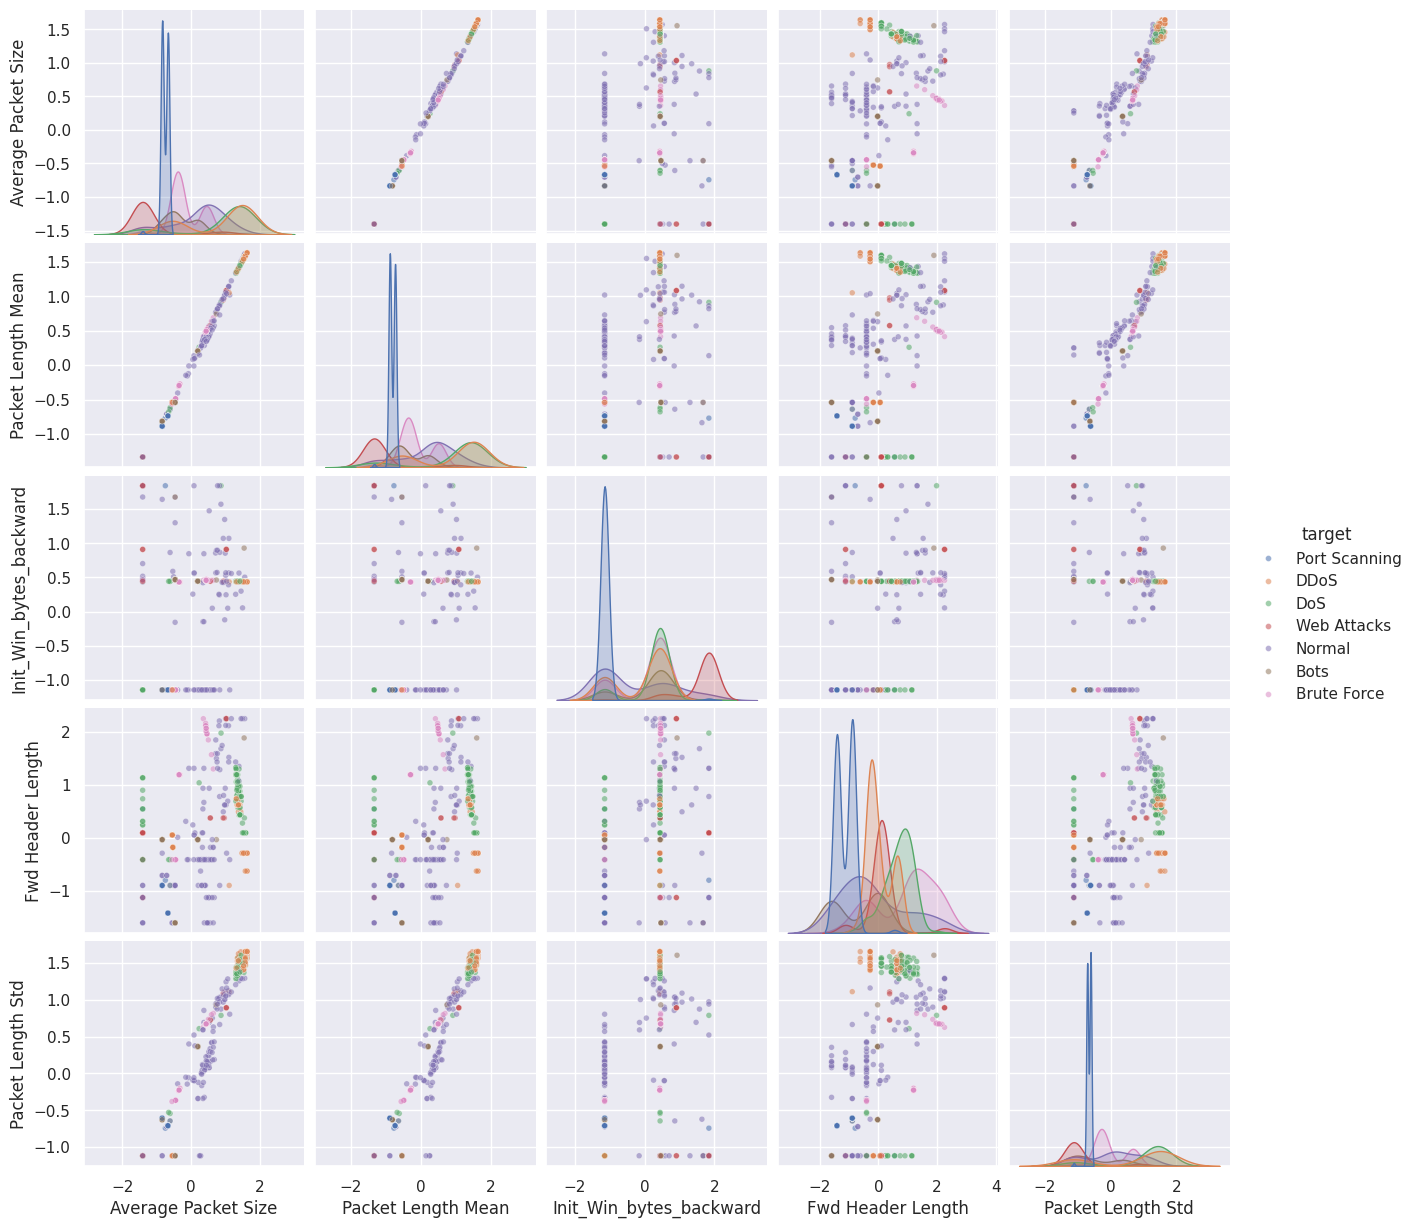

In [47]:
sns.pairplot(
    d.sample(800, random_state=42),
    vars=COLS, hue='target',
    diag_kind='kde',
    plot_kws={'s':18, 'alpha':0.55},
    diag_kws={'bw_adjust':1.2}
)
plt.show()


**sns.pairplot** is a function in the seaborn library in Python that is used to plot pairwise relationships between multiple variables in a dataset. The resulting plot is a grid of scatterplots, with each variable plotted against every other variable.

In [51]:
def make_initials(name):
    tokens = [t for t in name.replace('-', ' ').split() if t.isalpha()]
    return ''.join(t[0].upper() for t in tokens)[:4]

initials = [make_initials(n) for n in counts.index]
legend_map = {make_initials(n): n for n in counts.index}

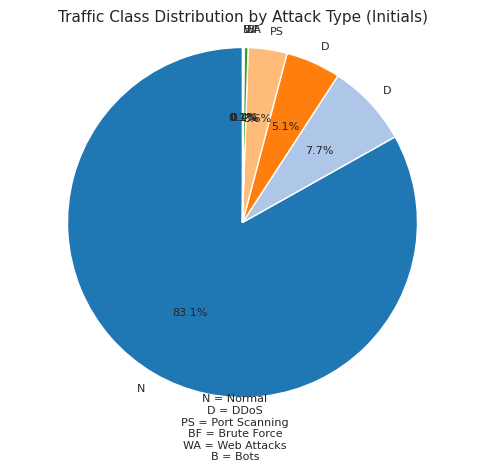

In [53]:
# 3) counts + initials
counts = df_small['target'].value_counts()

def make_initials(name):
    toks = [t for t in name.replace('-', ' ').split() if t.isalpha()]
    return ''.join(t[0].upper() for t in toks)[:4]

initials = [make_initials(n) for n in counts.index]
legend_map = {make_initials(n): n for n in counts.index}

# 4) smaller pie chart
fig, ax = plt.subplots(figsize=(6,5))
colors = plt.cm.tab20.colors[:len(initials)]

wedges, texts, autotexts = ax.pie(
    counts.values,
    labels=initials,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    radius=0.7,  # <--- this controls the pie size (smaller radius)
    textprops={'fontsize':8}
)
ax.set_title('Traffic Class Distribution by Attack Type (Initials)', fontsize=11)
ax.axis('equal')

# 5) legend under chart
legend_text = "\n".join([f"{k} = {v}" for k, v in legend_map.items()])
plt.figtext(0.5, 0.02, legend_text, ha='center', fontsize=8)

plt.show()

In [ ]:
def initials(s):
    s = s.replace('-', ' ').replace('_',' ')
    toks = [t for t in s.split() if t.isalpha()]
    return ''.join(w[0].upper() for w in toks)[:4]  # cap to 4 chars

counts = df_small['target'].value_counts()
labs   = [initials(c) for c in counts.index]

fig, ax = plt.subplots(figsize=(7,7))
colors = plt.cm.tab20.colors[:len(labs)]
ax.pie(counts.values, labels=labs, autopct='%1.1f%%', startangle=90,
       colors=colors, textprops={'fontsize':9})
ax.set_title('Traffic Class Distribution by Attack Type (Initials)')
ax.axis('equal')

legend_text = "\n".join(f"{initials(name)} = {name}" for name in counts.index)
plt.figtext(0.5, 0.01, legend_text, ha='center', fontsize=9)
plt.show()


**Data Matrix**

In [ ]:
X = df.drop(columns=['class'])
X.head(10)

In [ ]:
X.describe().transpose()

**Standardize the Data**

In [ ]:
Xs = StandardScaler().fit_transform(X)
Xcols = X.columns
X = pd.DataFrame(Xs)
X.columns = Xcols
X.head(10)

**Observations and variables**

In [ ]:
observations = list(df.index)
variables = list(df.columns)

**Box and Whisker Plots**

In [ ]:
ax = plt.figure()
ax = sns.boxplot(data=X, orient="v", palette="Set2")
# Rotate x-axis tick labels
ax.tick_params(axis='x', labelrotation=45)

In [ ]:
# Use swarmplot() or stripplot to show the datapoints on top of the boxes:
#plt. figure()
ax = plt.figure()
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax = sns.stripplot(data=X, color=".25")
ax.tick_params(axis='x', labelrotation=45)

**Correlation Matrix**

In [ ]:
ax = sns.heatmap(X.corr(), cmap='RdYlGn_r', linewidths=0.5, annot=True, cbar=False, square=True)
plt.yticks(rotation=0)
ax.tick_params(labelbottom=False,labeltop=True)
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='y', labelrotation=45)

#X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)
#sns.clustermap(X.corr(), annot=True, fmt='.2f')

##**Applying PCA**

In [ ]:
pca = PCA()
Z = pca.fit_transform(X)

# 1(Rosa)->0,  2(Kama)->1, 3(Canadian)->2
idx_Rosa = np.where(y == 0)
idx_Kana = np.where(y == 1)
idx_Canadian = np.where(y == 2)

plt. figure()
plt.scatter(Z[idx_Rosa,0], Z[idx_Rosa,1], c='r', label='Rosa')
plt.scatter(Z[idx_Kana,0], Z[idx_Kana,1], c='g', label='Kana')
plt.scatter(Z[idx_Canadian,0], Z[idx_Canadian,1], c='b', label='Canadian')
plt.legend()
plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')

**Eigenvectors**

In [ ]:
A = pca.components_.T

plt.scatter(A[:,0],A[:,1],c='r')
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for label, x, y in zip(variables, A[:, 0], A[:, 1]):
  plt.annotate(label, xy=(x, y), xytext=(-2, 2), textcoords='offset points', ha='right', va='bottom')

In [ ]:
plt.scatter(A[:, 0],A[:, 1], marker='o', c=A[:, 2], s=A[:, 3]*500, cmap=plt.get_cmap('Spectral'))
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for label, x, y in zip(variables,A[:, 0],A[:, 1]):
  plt.annotate(label,xy=(x, y), xytext=(-20, 20),
      textcoords='offset points', ha='right', va='bottom',
      bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
      arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

**Scree plot**

In [ ]:
#Eigenvalues
Lambda = pca.explained_variance_

#Scree plot
x = np.arange(len(Lambda)) + 1
plt.plot(x,Lambda/sum(Lambda), 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

**Explained Variance**

In [ ]:
ell = pca.explained_variance_ratio_
ind = np.arange(len(ell))
plt.bar(ind, ell, align='center', alpha=0.5)
plt.plot(np.cumsum(ell))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

**Biplot**

In [ ]:
# 0,1 denote PC1 and PC2; change values for other PCs
A1 = A[:,0]
A2 = A[:,1]
Z1 = Z[:,0]
Z2 = Z[:,1]

plt.figure()
plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')
for i in range(len(A1)):
# arrows project features as vectors onto PC axes
  plt.arrow(0, 0, A1[i]*max(Z1), A2[i]*max(Z2), color='k', width=0.0005, head_width=0.0025)
  plt.text(A1[i]*max(Z1)*1.2, A2[i]*max(Z2)*1.2,variables[i], color='k')

plt.scatter(Z[idx_Rosa,0], Z[idx_Rosa,1], c='r', label='Rosa')
plt.scatter(Z[idx_Kana,0], Z[idx_Kana,1], c='g', label='Kana')
plt.scatter(Z[idx_Canadian,0], Z[idx_Canadian,1], c='b', label='Canadian')
plt.legend(loc='upper left')

##**Using PCA Library**

In [ ]:
!pip install pca

In [ ]:
from pca import pca
# Initialize and keep all PCs
model = pca(n_components=0.85)
# Fit transform
out = model.fit_transform(X)

**Principal Components**

In [ ]:
out['PC']

**Scatter plot**

In [ ]:
model.scatter(label=True, legend=False)

**Eigenvectors**

In [ ]:
A = out['loadings'].T

In [ ]:
sns.scatterplot(data=A, x="PC1", y="PC2")
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for i in range(A.shape[0]):
 plt.text(x=A.PC1[i]+0.02,y=A.PC2[i]+0.02, s=variables[i],
          fontdict=dict(color='red',size=10),
          bbox=dict(facecolor='yellow',alpha=0.5))

**Scree Plot**

In [ ]:
VR = out['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

**Explained Variance Plot**

In [ ]:
model.plot();

**Biplot**

A biplot is a graphical representation of multivariate data that displays both observations and variables simultaneously in a single plot. Each observation is represented as a point in a two-dimensional plot, while the variables are represented as arrows or vectors that point in the direction of the greatest variation in the data. The length of the vector indicates the magnitude of the variable, while the angle between two vectors reflects their correlation.

In [ ]:
model.biplot(label=False, legend=False)

#**Multiclass Classification with PyCaret**

Multiclass classification is a supervised machine learning technique where the goal is to classify instances into one of three or more classes. (Classifying instances into one of two classes is called Binary Classification).

**Data Splitting**

In order to demonstrate the predict_model() function on unseen data, a sample of 21 observations has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 21 records were not available at the time when the machine learning experiment was performed.

In [ ]:
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

## **Install PyCaret**

PyCaret is an open-source, low-code machine learning library in Python designed to make the end-to-end machine learning process easier and faster for both beginners and experienced data scientists. It offers a variety of tools and functions for data preparation, model training, model selection, and deployment.

pip3 install pycaret==2.3.6 is a command used to install a specific version of the PyCaret library in Python. If you encounter an error message, try running the code again.

In [ ]:
# install slim version (default)
!pip install pycaret

**Setting up the Environment in PyCaret**

The **setup()** function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline.

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [ ]:
from pycaret.classification import *
clf = setup(data=data, target='class', train_size=0.7, session_id=123)

Once the setup has been succesfully executed it prints the information grid which contains several important pieces of information. Most of the information is related to the pre-processing pipeline which is constructed when setup() is executed. The majority of these features are out of scope for the purposes of this tutorial however a few important things to note at this stage include:

* **session_id** : A pseduo-random number distributed as a seed in all functions for later reproducibility. If no session_id is passed, a random number is automatically generated that is distributed to all functions. In this experiment, the session_id is set as 123 for later reproducibility.

* **Target Type** : Binary or Multiclass. The Target type is automatically detected and shown. There is no difference in how the experiment is performed for Binary or Multiclass problems. All functionalities are identical.

* **Label Encoded** : When the Target variable is of type string (i.e. 'Yes' or 'No') instead of 1 or 0, it automatically encodes the label into 1 and 0 and displays the mapping (0 : No, 1 : Yes) for reference.

* **Original Data** : Displays the original shape of the dataset. In this experiment (189, 8) means 189 samples and 8 features including the class column.

* **Missing Values** : When there are missing values in the original data this will show as True. For this experiment there are no missing values in the dataset.

* **Numeric Features** : The number of features inferred as numeric. In this dataset, 7 out of 8 features are inferred as numeric.

* **Categorical Features** : The number of features inferred as categorical. In this dataset, there are no categorical features.

* **Transformed Train Set** : Displays the shape of the transformed training set. Notice that the original shape of (189, 8) is transformed into (132, 7) for the transformed train set.

* **Transformed Test Set** : Displays the shape of the transformed test/hold-out set. There are 57 samples in test/hold-out set. This split is based on the default value of 70/30 that can be changed using the train_size parameter in setup.

Notice how a few tasks that are imperative to perform modeling are automatically handled such as missing value imputation, categorical encoding etc. Most of the parameters in setup() are optional and used for customizing the pre-processing pipeline.

**Comparing all Machine Learning Models**

In [ ]:
 #show the best model and their statistics
 best_model = compare_models()

In [ ]:
best_model

**Create a Model**

create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows Accuracy, Recall, Precision, F1, Kappa and MCC by fold.

For the remaining part of this tutorial, we will work with the below models as our candidate models. The selections are for illustration purposes only and do not necessarily mean they are the top performing or ideal for this type of data.

* Decision Tree Classifier ('dt')
* K Neighbors Classifier ('knn')
* Logistic Regression ('lr')

There are many classifiers available in the model library of PyCaret. Please view the create_model() docstring for the list of all available models.

**Create Decision Tree Classifier**

In [ ]:
dt = create_model('dt')

In [ ]:
#trained model object is stored in the variable 'dt'.
dt

**Tune a Model:** How to automatically tune the hyper-parameters of a multiclass model. When a model is created using the create_model() function it uses the default hyperparameters. In order to tune hyperparameters, the tune_model() function is used. The tune_model() function is a random grid search of hyperparameters over a pre-defined search space. By default, it is set to optimize Accuracy but this can be changed using optimize parameter. This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold.

**Tune Decision Tree Model**

In [ ]:
tuned_dt = tune_model(dt)

In [ ]:
#tuned model object is stored in the variable 'tuned_dt'.
tuned_dt

**Evaluate Decision Tree Model**

How to analyze model performance using various plots

In [ ]:
evaluate_model(tuned_dt)

**Create K Neighbors Model**

In [ ]:
knn = create_model('knn')

**Tune K Neighbors Model**

In [ ]:
tuned_knn = tune_model(knn, custom_grid = {'n_neighbors' : np.arange(0,50,1)})

**Evaluate K Neighbors Model**

In [ ]:
evaluate_model(tuned_knn)

**Create Logistic Regression Model**

In [ ]:
lr = create_model('lr')

In [ ]:
lr

**Tune Logistic Regression Model**

In [ ]:
tuned_lr = tune_model(lr)

**Evaluate Logistic Regression Model**

In [ ]:
tuned_lr

In [ ]:
evaluate_model(tuned_lr)

**Create Random Forest Model**

In [ ]:
rf = create_model('rf')

**Tune Random Forest Model**

In [ ]:
tuned_rf = tune_model(rf)

**Evaluate Random Forest Model**

In [ ]:
evaluate_model(tuned_rf)

#**Tune the Best Model**

In [ ]:
# Tune hyperparameters with scikit-learn (default)
tuned_best_model = tune_model(best_model)

In [ ]:
tuned_best_model

**Evaluate the Best Model**

One way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [ ]:
evaluate_model(tuned_best_model)

#**Classification + PCA**

In [ ]:
clf_pca = setup(data=df, target='class', train_size=0.7, session_id=123, normalize = True, pca = True, pca_components = 3)

In [ ]:
#show the best model and their statistics
best_model_pca = compare_models()

In [ ]:
best_model_pca

**Tune the Best Model**

In [ ]:
# Tune hyperparameters with scikit-learn (default)
tuned_best_model_pca = tune_model(best_model_pca)

In [ ]:
tuned_best_model_pca

**Evaluate the Best Model**

One way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [ ]:
evaluate_model(tuned_best_model_pca)

**Note:** The AUC metric is not available for Multiclass classification however the column will still be shown with zero values to maintain consistency between the Binary Classification and Multiclass Classification display grids.

In [ ]:
 rf_pca = create_model('rf')

In [ ]:
tuned_rf_pca = tune_model(rf_pca)

#**Explainable AI with Shapley values**

Shapley values are a widely used approach from cooperative game theory that come with desirable properties.

## **Install Analysis Extras for Explainable AI**

In [ ]:
!pip install pycaret[analysis]

**SHAP Summary Plot**

Rather than using a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples.

In [ ]:
interpret_model(tuned_rf_pca, plot='summary')

In [ ]:
#explainer = shap.TreeExplainer(tuned_rf_pca)
#X = df.drop('class', axis=1)
#shap_values = explainer.shap_values(X)
#shap.summary_plot(shap_values, X)

**Visualize a single prediction**

In [ ]:
interpret_model(tuned_rf_pca, plot='reason', observation=32)

From the above the plot, we can see the "base value," which is defined as the mean predicted target; and f(x), which is the prediction for a selected observation (i.e. observation number 32). The red-colored features increased the predicted value, while the blue-colored features decreased it. The size of each feature (i.e. Principal Component) indicates the impact it has on the model.

**Visualize many predictions**

In [ ]:
interpret_model(tuned_rf_pca, plot='reason')